In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ot

from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot
from partial_gw import pu_w_emd 
from partial_gw import compute_cost_matrices

from matplotlib import font_manager as font_manager

# !pip install POT

c:\Users\bilal\anaconda3\envs\pytorch\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# Generate Data

In [2]:
m = 100
n = 400

np.random.seed(0)


def gen_func(m,start_angle=0,end_angle=2*np.pi,scale_param=1,n_sectors=4):
    theta = np.random.uniform(low=start_angle,high=end_angle,size=(m,1))
    radii = np.random.exponential(scale=scale_param,size=(8*m)) # over sample enough
    radii =  radii[radii>scale_param*np.log(2)][0:m] # reject those near the center and grab m
    x = radii[:,np.newaxis]*np.hstack((np.cos(theta),np.sin(theta)))
    mode_index = np.floor(n_sectors*(theta)/np.pi) # class label is sector
    return x, mode_index

offset = np.pi/2
xt,lt = gen_func(m,offset,offset+np.pi/4) # target is one quadrant
xs,ls = gen_func(n,offset-np.pi/2,offset+np.pi/2) # source is uniform angles on right half plan

mu,nu = np.ones((m,)) / m, np.ones((n,)) / n  # uniform distribution on samples

true_k = np.sum(np.in1d(ls,np.unique(lt)))
c_true = n/true_k

def compute_accuracy(true_labels, nu_pu_star, positive_class_label, true_k):
    '''
    true_labels: multivariate labels which are not necessarily binary
    nu_pu_star: mass assignment vector
    positive_class_label: label of positive class in true_labels, it must be number
    true_k: prior proportion of positive numbers/ it depends in positivity prior and it must be a positive integer
    '''
    labels_assigned = np.zeros_like(nu_pu_star.squeeze())
    nu_asc_idx = np.argsort(nu_pu_star)
    labels_assigned[nu_asc_idx[-true_k:]] = 1
    y_true = np.array(true_labels.squeeze() == positive_class_label).astype(float)
    
    return np.mean(y_true == labels_assigned)


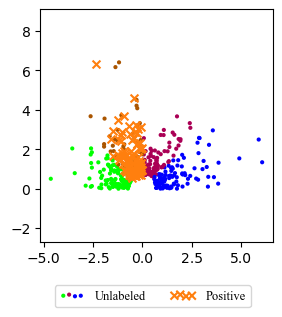

In [3]:
font_title = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'bold',
        'size': 9,
        }

font_legend = font_manager.FontProperties(family='Times New Roman',
                                   weight='normal',
                                   style='normal', size=9)

# plt.figure(1)
fig, ax = plt.subplots(1,1, figsize=(3.0, 3.8))

ax.scatter(xs[:, 0], xs[:, 1], c=ls, label='Unlabeled', marker='.', edgecolors='None', cmap = "brg")
ax.scatter(xt[:, 0], xt[:, 1], s =32, facecolor = "C1", label='Positive', marker='x')

ax.set_xlim([np.minimum(np.min(xs[:,0]), np.min(xt[:,0])) - 0.5, np.maximum(np.max(xs[:,0]), np.max(xt[:,0])) + 0.5])
ax.set_ylim([np.minimum(np.min(xs[:,1]), np.min(xt[:,1])) - 0.5, np.maximum(np.max(xs[:,1]), np.max(xt[:,1])) + 0.5])
# ax.legend(loc=1, scatterpoints=4, prop=font_legend)
# ax.set_title('Positive and unlabeled distributions', fontdict=font_title)
ax.set_box_aspect(1)
ax.axis("equal")
fig.legend(ncol=2, scatterpoints=4, bbox_transform=fig.transFigure, loc='lower center',  bbox_to_anchor=(0.5, 0.001), fontsize=9, prop=font_legend)
plt.show()

fig.savefig('pu_learning_toy_data.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
fig.savefig('pu_learning_toy_data.png', dpi=500, bbox_inches = 'tight', format='png')
fig.savefig('pu_learning_toy_data.svg', dpi=500, bbox_inches = 'tight', format='svg')

# Chapel 2020 PU learning 

In [4]:
n_dummies = 10
Ctot, _, _, mu_pu, nu_pu = compute_cost_matrices(xt, xs, prior = 1/c_true, nb_dummies=n_dummies)
P_pu0 = pu_w_emd(mu_pu, nu_pu, Ctot, nb_dummies=n_dummies)
P_pu = P_pu0[:-n_dummies, :]
P_pu[P_pu<1e-6] = 0
nu_pu_star = np.sum(P_pu,axis=0)

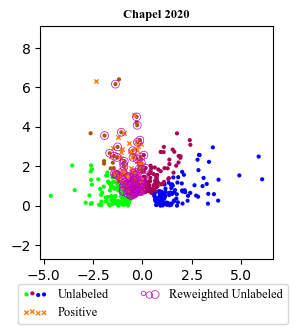

In [5]:
fig1, ax1 = plt.subplots(1,1,figsize=(3.0, 3.8))

ax1.scatter(xs[:, 0], xs[:, 1], c=ls, label='Unlabeled',marker='.', edgecolors='None', cmap = "brg")
ax1.scatter(xt[:, 0], xt[:, 1], c='C1',label='Positive', marker='x',s=10,linewidth=1)
ax1.scatter(xs[:, 0], xs[:, 1], edgecolors='m', label='Reweighted Unlabeled', s=32*nu_pu_star/np.max(nu_pu_star),facecolors='None',linewidth=0.5)

ax1.set_xlim([np.minimum(np.min(xs[:,0]), np.min(xt[:,0])) - 0.5, np.maximum(np.max(xs[:,0]), np.max(xt[:,0])) + 0.5])
ax1.set_ylim([np.minimum(np.min(xs[:,1]), np.min(xt[:,1])) - 0.5, np.maximum(np.max(xs[:,1]), np.max(xt[:,1])) + 0.5])

# plt.axis('equal')
ax1.set_title(r'Chapel 2020', fontdict=font_title)
ax1.set_box_aspect(1)
ax1.axis("equal")
fig1.legend(ncol=2, scatterpoints=4, loc='lower center',  bbox_to_anchor=(0.5, 0.001), fontsize=9, prop=font_legend)

fig1.savefig('pu_learning_toy_data_sr_chapel_2020_0.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
fig1.savefig('pu_learning_toy_data_sr_chapel_2020_0.png', dpi=500, bbox_inches = 'tight', format='png')
fig1.savefig('pu_learning_toy_data_sr_chapel_2020_0.svg', dpi=500, bbox_inches = 'tight', format='svg')

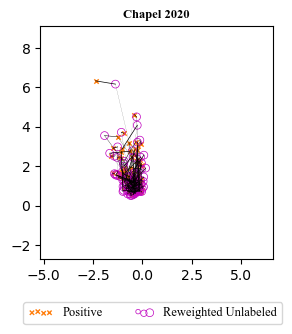

In [6]:
fig2, ax2 = plt.subplots(1,1,figsize=(3.0, 3.8))

# ax2.scatter(xs[:, 0], xs[:, 1], c=ls, label='Unlabeled',marker='.', edgecolors='None', cmap = "brg")
ax2.scatter(xt[:, 0], xt[:, 1], c='C1',label='Positive', marker='x',s=10,linewidth=1)
ax2.scatter(xs[:, 0], xs[:, 1], edgecolors='m', label='Reweighted Unlabeled', s=32*nu_pu_star/np.max(nu_pu_star),facecolors='None',linewidth=0.5)

for i in range(m):
    for j in range(n):
        if P_pu[i,j]>0:
            ax2.plot(np.vstack((xt[i, 0], xs[j,0])), np.vstack((xt[i, 1], xs[j,1])), linewidth=P_pu[i,j]*50*c_true, c='k')

ax2.set_xlim([np.minimum(np.min(xs[:,0]), np.min(xt[:,0])) - 0.5, np.maximum(np.max(xs[:,0]), np.max(xt[:,0])) + 0.5])
ax2.set_ylim([np.minimum(np.min(xs[:,1]), np.min(xt[:,1])) - 0.5, np.maximum(np.max(xs[:,1]), np.max(xt[:,1])) + 0.5])

# plt.axis('equal')
ax2.set_title(r'Chapel 2020', fontdict=font_title)
ax2.set_box_aspect(1)
ax2.axis("equal")
fig2.legend(ncol=2, scatterpoints=4, loc='lower center',  bbox_to_anchor=(0.5, 0.001), fontsize=9, prop=font_legend)

fig2.savefig('pu_learning_toy_data_sr_chapel_2020_1.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
fig2.savefig('pu_learning_toy_data_sr_chapel_2020_1.png', dpi=500, bbox_inches = 'tight', format='png')
fig2.savefig('pu_learning_toy_data_sr_chapel_2020_1.svg', dpi=500, bbox_inches = 'tight', format='svg')

In [7]:
compute_accuracy(ls, nu_pu_star, positive_class_label=np.unique(lt).item(), true_k=true_k)

0.935

In [8]:
# cost matrix
M = ot.dist(xt, xs)
M /= M.max()

# Subset Selection

In [9]:
true_k = np.sum(np.in1d(ls,np.unique(lt)))
c_true = n/true_k


In [10]:
gamma_ss = 0.01
xp = xt
xu = xs
c = c_true
costs, P, _, _ = ss_ipot(xp, xu, mu, nu, c, gamma=gamma_ss, max_outer_iter=1000, max_inner_iter=5, return_map=True )
P[P<1e-8] = 0
nu0_star = np.sum(P,axis=0)


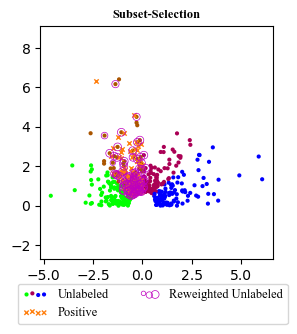

In [11]:
fig1, ax1 = plt.subplots(1,1,figsize=(3.0, 3.8))

ax1.scatter(xs[:, 0], xs[:, 1], c=ls, label='Unlabeled',marker='.', edgecolors='None', cmap = "brg")
ax1.scatter(xt[:, 0], xt[:, 1], c='C1',label='Positive', marker='x',s=10,linewidth=1)
ax1.scatter(xs[:, 0], xs[:, 1], edgecolors='m', label='Reweighted Unlabeled', s=32*nu0_star/np.max(nu0_star),facecolors='None',linewidth=0.5)

ax1.set_xlim([np.minimum(np.min(xs[:,0]), np.min(xt[:,0])) - 0.5, np.maximum(np.max(xs[:,0]), np.max(xt[:,0])) + 0.5])
ax1.set_ylim([np.minimum(np.min(xs[:,1]), np.min(xt[:,1])) - 0.5, np.maximum(np.max(xs[:,1]), np.max(xt[:,1])) + 0.5])

# plt.axis('equal')
ax1.set_title(r'Subset-Selection', fontdict=font_title)
ax1.set_box_aspect(1)
ax1.axis("equal")
fig1.legend(ncol=2, scatterpoints=4, loc='lower center',  bbox_to_anchor=(0.5, 0.001), fontsize=9, prop=font_legend)

fig1.savefig('pu_learning_toy_data_sr_ss.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
fig1.savefig('pu_learning_toy_data_sr_ss.png', dpi=500, bbox_inches = 'tight', format='png')
fig1.savefig('pu_learning_toy_data_sr_ss.svg', dpi=500, bbox_inches = 'tight', format='svg')

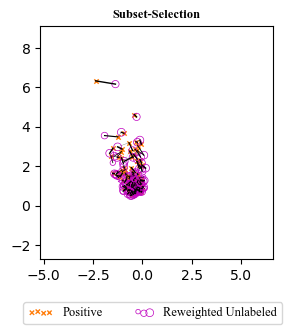

In [12]:
fig2, ax2 = plt.subplots(1,1,figsize=(3.0, 3.8))

# ax2.scatter(xs[:, 0], xs[:, 1], c=ls, label='Unlabeled',marker='.', edgecolors='None', cmap = "brg")
ax2.scatter(xt[:, 0], xt[:, 1], c='C1',label='Positive', marker='x',s=10,linewidth=1)
ax2.scatter(xs[:, 0], xs[:, 1], edgecolors='m', label='Reweighted Unlabeled', s=32*nu0_star/np.max(nu0_star),facecolors='None',linewidth=0.5)

for i in range(m):
    for j in range(n):
        if P[i,j]>0:
            ax2.plot(np.vstack((xt[i, 0], xs[j,0])), np.vstack((xt[i, 1], xs[j,1])), linewidth=P[i,j]*100, c='k')

ax2.set_xlim([np.minimum(np.min(xs[:,0]), np.min(xt[:,0])) - 0.5, np.maximum(np.max(xs[:,0]), np.max(xt[:,0])) + 0.5])
ax2.set_ylim([np.minimum(np.min(xs[:,1]), np.min(xt[:,1])) - 0.5, np.maximum(np.max(xs[:,1]), np.max(xt[:,1])) + 0.5])

# plt.axis('equal')
ax2.set_title(r'Subset-Selection', fontdict=font_title)
ax2.set_box_aspect(1)
ax2.axis('equal')
fig2.legend(ncol=2, scatterpoints=4, loc='lower center',  bbox_to_anchor=(0.5, 0.001), fontsize=9, prop=font_legend)

fig2.savefig('pu_learning_toy_data_sr_ss1.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
fig2.savefig('pu_learning_toy_data_sr_ss1.png', dpi=500, bbox_inches = 'tight', format='png')
fig2.savefig('pu_learning_toy_data_sr_ss1.svg', dpi=500, bbox_inches = 'tight', format='svg')

In [13]:
compute_accuracy(ls, nu0_star, positive_class_label=np.unique(lt).item(), true_k=true_k)

0.935

# Semi-relaxed Partial optimal Transport

In [14]:
T = ot.partial.partial_wasserstein(1/c_true*mu, nu, M, m=np.sum(1/(c_true+1e-15)*mu))
P = c_true*T
P[P<1e-8] = 0

nu_star = np.sum(P,axis=0,keepdims=True).T

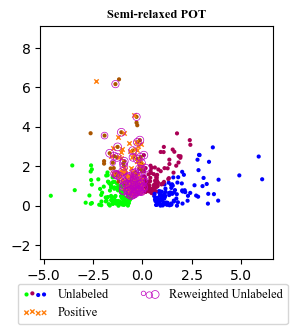

In [15]:
fig1, ax1 = plt.subplots(1,1,figsize=(3.0, 3.8))

ax1.scatter(xs[:, 0], xs[:, 1], c=ls, label='Unlabeled',marker='.', edgecolors='None', cmap = "brg")
ax1.scatter(xt[:, 0], xt[:, 1], c='C1',label='Positive', marker='x',s=10,linewidth=1)
ax1.scatter(xs[:, 0], xs[:, 1], edgecolors='m', label='Reweighted Unlabeled', s=32*nu_star/np.max(nu_star),facecolors='None',linewidth=0.5)

ax1.set_xlim([np.minimum(np.min(xs[:,0]), np.min(xt[:,0])) - 0.5, np.maximum(np.max(xs[:,0]), np.max(xt[:,0])) + 0.5])
ax1.set_ylim([np.minimum(np.min(xs[:,1]), np.min(xt[:,1])) - 0.5, np.maximum(np.max(xs[:,1]), np.max(xt[:,1])) + 0.5])

# plt.axis('equal')
ax1.set_title(r'Semi-relaxed POT', fontdict=font_title)
ax1.set_box_aspect(1)
ax1.axis('equal')
fig1.legend(ncol=2, scatterpoints=4, loc='lower center',  bbox_to_anchor=(0.5, 0.001), fontsize=9, prop=font_legend)

fig1.savefig('pu_learning_toy_data_sr_partial.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
fig1.savefig('pu_learning_toy_data_sr_partial.png', dpi=500, bbox_inches = 'tight', format='png')
fig1.savefig('pu_learning_toy_data_sr_partial.svg', dpi=500, bbox_inches = 'tight', format='svg')

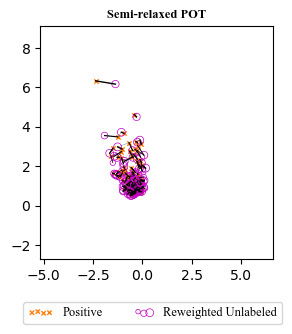

In [16]:
fig2, ax2 = plt.subplots(1,1,figsize=(3.0, 3.8))

# ax2.scatter(xs[:, 0], xs[:, 1], c=ls, label='Unlabeled',marker='.', edgecolors='None', cmap = "brg")
ax2.scatter(xt[:, 0], xt[:, 1], c='C1',label='Positive', marker='x',s=10,linewidth=1)
ax2.scatter(xs[:, 0], xs[:, 1], edgecolors='m', label='Reweighted Unlabeled', s=32*nu_star/np.max(nu_star),facecolors='None',linewidth=0.5)

for i in range(m):
    for j in range(n):
        if P[i,j]>0:
            ax2.plot(np.vstack((xt[i, 0], xs[j,0])), np.vstack((xt[i, 1], xs[j,1])), linewidth=P[i,j]*100, c='k')

ax2.set_xlim([np.minimum(np.min(xs[:,0]), np.min(xt[:,0])) - 0.5, np.maximum(np.max(xs[:,0]), np.max(xt[:,0])) + 0.5])
ax2.set_ylim([np.minimum(np.min(xs[:,1]), np.min(xt[:,1])) - 0.5, np.maximum(np.max(xs[:,1]), np.max(xt[:,1])) + 0.5])

# plt.axis('equal')
ax2.set_title(r'Semi-relaxed POT', fontdict=font_title)
ax2.set_box_aspect(1)
ax2.axis('equal')
fig2.legend(ncol=2, scatterpoints=4, loc='lower center',  bbox_to_anchor=(0.5, 0.001), fontsize=9, prop=font_legend)

fig2.savefig('pu_learning_toy_data_sr_partial1.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
fig2.savefig('pu_learning_toy_data_sr_partial1.png', dpi=500, bbox_inches = 'tight', format='png')
fig2.savefig('pu_learning_toy_data_sr_partial1.svg', dpi=500, bbox_inches = 'tight', format='svg')

In [17]:
compute_accuracy(ls, nu_star, positive_class_label=2, true_k=true_k)

0.78

# Fully-relaxed Partial Optimal Transport

In [18]:
T = ot.partial.partial_wasserstein(mu, nu, M, m=1/c_true)

P2 = c_true*T
P2[P2<1e-8] = 0
nu2_star = np.sum(P2,axis=0,keepdims=True).T
mu_star = np.sum(P2,axis=1,keepdims=True)


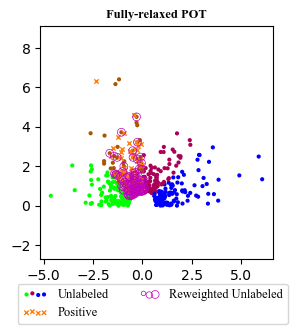

In [19]:
fig1, ax1 = plt.subplots(1,1,figsize=(3.0, 3.8))

ax1.scatter(xs[:, 0], xs[:, 1], c=ls, label='Unlabeled',marker='.', edgecolors='None', cmap = "brg")
ax1.scatter(xt[:, 0], xt[:, 1], c='C1',label='Positive', marker='x',s=10,linewidth=1)
ax1.scatter(xs[:, 0], xs[:, 1], edgecolors='m', label='Reweighted Unlabeled', s=32*nu2_star/np.max(nu2_star),facecolors='None',linewidth=0.5)

ax1.set_xlim([np.minimum(np.min(xs[:,0]), np.min(xt[:,0])) - 0.5, np.maximum(np.max(xs[:,0]), np.max(xt[:,0])) + 0.5])
ax1.set_ylim([np.minimum(np.min(xs[:,1]), np.min(xt[:,1])) - 0.5, np.maximum(np.max(xs[:,1]), np.max(xt[:,1])) + 0.5])

# plt.axis('equal')
ax1.set_title(r'Fully-relaxed POT', fontdict=font_title)
ax1.set_box_aspect(1)
ax1.axis('equal')
fig1.legend(ncol=2, scatterpoints=4, loc='lower center',  bbox_to_anchor=(0.5, 0.001), fontsize=9, prop=font_legend)

fig1.savefig('pu_learning_toy_data_fr_partial.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
fig1.savefig('pu_learning_toy_data_fr_partial.png', dpi=500, bbox_inches = 'tight', format='png')
fig1.savefig('pu_learning_toy_data_fr_partial.svg', dpi=500, bbox_inches = 'tight', format='svg')

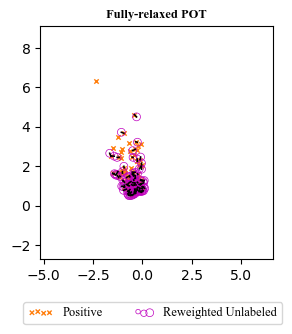

In [20]:
fig2, ax2 = plt.subplots(1,1,figsize=(3.0, 3.8))

# ax2.scatter(xs[:, 0], xs[:, 1], c=ls, label='Unlabeled',marker='.', edgecolors='None', cmap = "brg")
ax2.scatter(xt[:, 0], xt[:, 1], c='C1',label='Positive', marker='x',s=10,linewidth=1)
ax2.scatter(xs[:, 0], xs[:, 1], edgecolors='m', label='Reweighted Unlabeled', s=32*nu2_star/np.max(nu2_star),facecolors='None',linewidth=0.5)

for i in range(m):
    for j in range(n):
        if P2[i,j]>0:
            ax2.plot(np.vstack((xt[i, 0], xs[j,0])), np.vstack((xt[i, 1], xs[j,1])), linewidth=P2[i,j]*100, c='k')

ax2.set_xlim([np.minimum(np.min(xs[:,0]), np.min(xt[:,0])) - 0.5, np.maximum(np.max(xs[:,0]), np.max(xt[:,0])) + 0.5])
ax2.set_ylim([np.minimum(np.min(xs[:,1]), np.min(xt[:,1])) - 0.5, np.maximum(np.max(xs[:,1]), np.max(xt[:,1])) + 0.5])

# plt.axis('equal')
ax2.set_title(r'Fully-relaxed POT', fontdict=font_title)
ax2.set_box_aspect(1)
ax2.axis('equal')
fig2.legend(ncol=2, scatterpoints=4, loc='lower center',  bbox_to_anchor=(0.5, 0.001), fontsize=9, prop=font_legend)

fig2.savefig('pu_learning_toy_data_fr_partial1.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
fig2.savefig('pu_learning_toy_data_fr_partial1.png', dpi=500, bbox_inches = 'tight', format='png')
fig2.savefig('pu_learning_toy_data_fr_partial1.svg', dpi=500, bbox_inches = 'tight', format='svg')

In [21]:
compute_accuracy(ls, nu2_star, positive_class_label=2, true_k=true_k)

0.78

# Verifying Statistically that Subset Selection can perform better than subset selection in toy cases

In [22]:
idx_pu = np.argsort(nu_pu_star.ravel())[::-1]
idx0 = np.argsort(nu0_star.ravel())[::-1]
idx = np.argsort(nu_star.ravel())[::-1]
idx2 = np.argsort(nu2_star.ravel())[::-1]

precision_at_k = lambda idx: np.cumsum(np.in1d(ls[idx],np.unique(lt)))/np.arange(1,n+1)
print(precision_at_k(idx_pu)[true_k])
print(precision_at_k(idx0)[true_k])
print(precision_at_k(idx)[true_k])
print(precision_at_k(idx2)[true_k])

0.8409090909090909
0.8522727272727273
0.8409090909090909
0.7954545454545454


In [23]:
def ss_subset(mu, nu, xt, xs, true_k):
    xp = xt
    xu = xs
    c = c_true
    costs, P, _, _ = ss_ipot(xp, xu, mu, nu, c, gamma=gamma_ss, max_outer_iter=200, max_inner_iter=20, return_map=True )
    nu0_star = np.sum(P,axis=0)
    
    return nu0_star

def sr_subset(mu,nu,xt,xs,true_k):
    n = len(xs)
    c_true = n/true_k
    M = ot.dist(xt, xs)
    M /= M.max()
    T = ot.partial.partial_wasserstein(1/c_true*mu, nu, M, m=np.sum(1/(c_true+1e-15)*mu))
    P = c_true*T
    nu_star = np.sum(P,axis=0,keepdims=True).T
    return nu_star


def fr_subset(mu,nu,xt,xs,true_k):
    n = len(xs)
    c_true = n/true_k
    M = ot.dist(xt, xs)
    M /= M.max()
    T = ot.partial.partial_wasserstein(mu, nu, M, m=1/c_true)
    P = c_true*T
    nu_star = np.sum(P,axis=0,keepdims=True).T
    return nu_star

In [25]:
def eval_given_k(lt,ls,nu_star,true_k):
    n = len(ls)
    idx = np.argsort(nu_star.ravel())[::-1]
    precision_at_k = lambda idx: np.cumsum(np.in1d(ls[idx],np.unique(lt)))/np.arange(1,n+1)
    return precision_at_k(idx)[true_k]


In [26]:
m = 100
nranges = np.linspace(100,800,16,dtype=int)
target_angle_starts = np.pi*np.array([-0.25, 0, 1/4, 1/2-1/8 ])

offset = 0
def gen_func(m,start_angle=0,end_angle=2*np.pi,scale_param=1,n_sectors=4):
    theta = np.random.uniform(low=start_angle,high=end_angle,size=(m,1))
    radii = np.random.exponential(scale=scale_param,size=(8*m)) # over sample enough
    radii =  radii[radii>scale_param*np.log(2)][0:m] # reject those near the center and grab m
    x = radii[:,np.newaxis]*np.hstack((np.cos(theta),np.sin(theta)))
    mode_index = np.floor(n_sectors*(theta)/np.pi) # class label is sector
    return x, mode_index

nmonte = 100

acc0 = np.zeros((len(nranges), nmonte,len(target_angle_starts)))
acc1 = np.zeros((len(nranges), nmonte,len(target_angle_starts)))
acc2 = np.zeros((len(nranges), nmonte,len(target_angle_starts)))

for i,n in enumerate(nranges):
    for j,angle_start in enumerate(target_angle_starts):
        for monte_seed in range(nmonte):
            np.random.seed(monte_seed)

            xt,lt = gen_func(m,offset+angle_start,offset+np.pi/2) # target is one quadrant
            # print("start_angle = ", offset+angle_start)
            # print("start_angle = ", offset + np.pi/2)
            
            xs,ls = gen_func(n,offset-np.pi/2,offset+np.pi/2) # source is uniform angles on right half plan
            mu,nu = np.ones((m,)) / m, np.ones((n,)) / n  # uniform distribution on samples

            true_k = np.sum(np.in1d(ls,np.unique(lt)))
            # acc0[i,monte_seed,j] = eval_given_k(lt,ls,ss_subset(mu,nu,xt,xs,true_k),true_k)
            acc1[i,monte_seed,j] = eval_given_k(lt,ls,sr_subset(mu,nu,xt,xs,true_k),true_k)
            acc2[i,monte_seed,j] = eval_given_k(lt,ls,fr_subset(mu,nu,xt,xs,true_k),true_k)




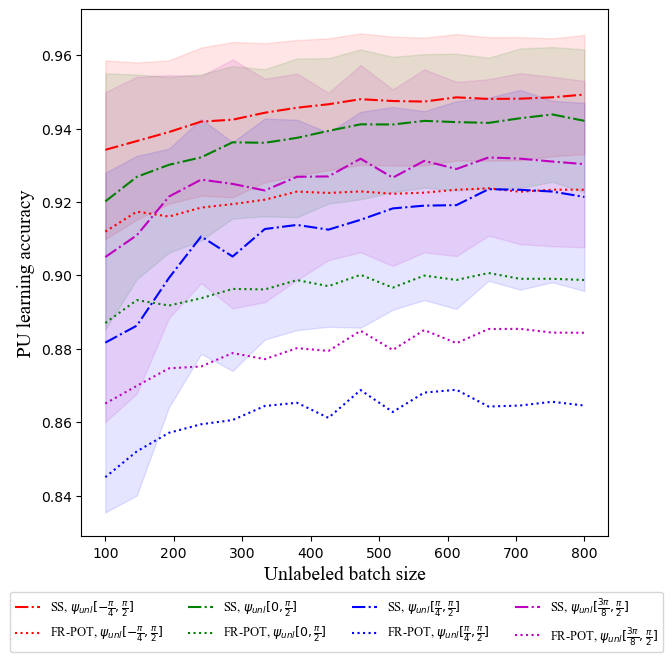

In [27]:
import matplotlib as mpl
fig, ax = plt.subplots(1,1,figsize=(6.8, 7.8))
font_labels = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 14}

# colors0 = colors0 = mpl.cm.jet(range(4))
colors0 = ["r", "g","b", "m"]
means_acc1 = np.mean(acc1,axis=1)
means_acc2 = np.mean(acc2,axis=1)
target_angle_starts = np.pi*np.array([-0.25, 0, 1/4, 1/2-1/8 ])
target_angle_starts_strs = ["$[-\\frac{\\pi}{4},\\frac{\\pi}{2}]$", "$[0, \\frac{\\pi}{2}]$", "$[\\frac{\\pi}{4},\\frac{\\pi}{2}]$", "$[\\frac{3\\pi}{8},\\frac{\\pi}{2}]$", ]

for j in range(len(target_angle_starts)):
    label_j = '$\\psi_{unl}}\\in$' + target_angle_starts_strs[j]
    ax.plot(nranges,means_acc1[:, j],'-.', label = "SS, " + label_j, color = colors0[j])
    ax.plot(nranges,means_acc2[:, j],':', label = "FR-POT, "+label_j , color = colors0[j])

    ax.fill_between(nranges,means_acc1[:,j]+np.std(acc1,axis=1)[:,j],means_acc1[:,j]-np.std(acc1,axis=1)[:,j],alpha=0.1, color = colors0[j])

ax.set_xlabel("Unlabeled batch size", font_labels)
ax.set_ylabel("PU learning accuracy", font_labels)

ax.set_box_aspect(1)

fig.legend(ncol=4, scatterpoints=4, loc='lower center',  bbox_to_anchor=(0.5, 0.001), fontsize=9, prop=font_legend)

fig.savefig('pu_learning_toy_data_fr_partial_ss.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
fig.savefig('pu_learning_toy_data_fr_partial_ss.png', dpi=500, bbox_inches = 'tight', format='png')
fig.savefig('pu_learning_toy_data_fr_partial_ss.svg', dpi=500, bbox_inches = 'tight', format='svg')


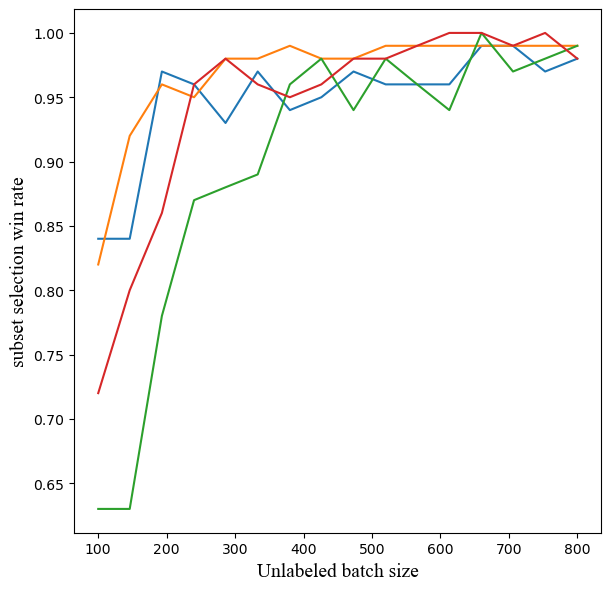

In [28]:
fig, ax = plt.subplots(1,1,figsize=(6.8, 6.8))

ax.plot(nranges,np.mean(acc1>acc2,axis=1),'-')
ax.set_xlabel("Unlabeled batch size", fontdict=font_labels)
ax.set_ylabel("subset selection win rate", fontdict=font_labels)
fig.savefig('pu_learning_toy_data_fr_partial_ss1.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
fig.savefig('pu_learning_toy_data_fr_partial_ss1.png', dpi=500, bbox_inches = 'tight', format='png')
fig.savefig('pu_learning_toy_data_fr_partial_ss1.svg', dpi=500, bbox_inches = 'tight', format='svg')

0


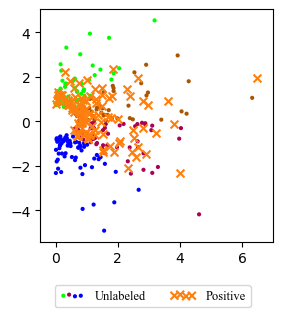

0


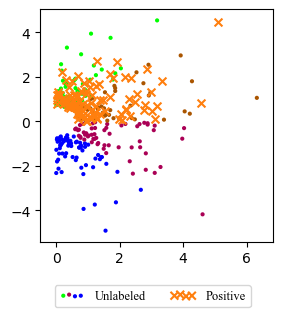

0


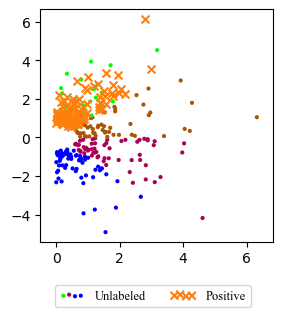

0


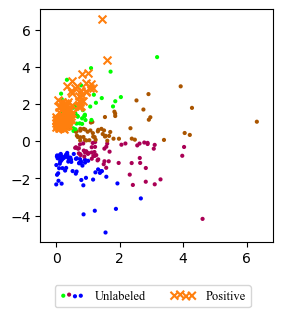

In [39]:
# plt.figure(1)
offset = 0
for n in nranges[3:4]:
    for j,angle_start in enumerate(target_angle_starts):
        for monte_seed in range(0,1):
            print(monte_seed)
            np.random.seed(monte_seed)

            xt,lt = gen_func(m,offset+angle_start,offset+np.pi/2) # target is one quadrant
            xs,ls = gen_func(n,offset-np.pi/2,offset+np.pi/2) # source is uniform angles on right half plan
            mu,nu = np.ones((m,)) / m, np.ones((n,)) / n  # uniform distribution on samples

            true_k = np.sum(np.in1d(ls,np.unique(lt)))


            fig, ax = plt.subplots(1,1, figsize=(3.0, 3.8))

            ax.scatter(xs[:, 0], xs[:, 1], c=ls, label='Unlabeled', marker='.', edgecolors='None', cmap = "brg")
            ax.scatter(xt[:, 0], xt[:, 1], s =32, facecolor = "C1", label='Positive', marker='x')

            ax.set_xlim([np.minimum(np.min(xs[:,0]), np.min(xt[:,0])) - 0.5, np.maximum(np.max(xs[:,0]), np.max(xt[:,0])) + 0.5])
            ax.set_ylim([np.minimum(np.min(xs[:,1]), np.min(xt[:,1])) - 0.5, np.maximum(np.max(xs[:,1]), np.max(xt[:,1])) + 0.5])
            # ax.legend(loc=1, scatterpoints=4, prop=font_legend)
            # ax.set_title('Positive and unlabeled distributions', fontdict=font_title)
            ax.set_box_aspect(1)
            fig.legend(ncol=2, scatterpoints=4, bbox_transform=fig.transFigure, loc='lower center',  bbox_to_anchor=(0.5, 0.001), fontsize=9, prop=font_legend)
            plt.show()
            name_str = '_{}_{}'.format(n,j)
            fig.savefig('pu_learning_toy_data'+name_str+'.pdf', dpi=500, bbox_inches = 'tight', format='pdf')
            fig.savefig('pu_learning_toy_data'+name_str+'.png', dpi=500, bbox_inches = 'tight', format='png')
            fig.savefig('pu_learning_toy_data'+name_str+'.svg', dpi=500, bbox_inches = 'tight', format='svg')